# Table of Contents

- [Table of Contents](#table-of-contents)
- [0. Introduction](#0.-Introduction)
- [1. Data Exploration](#1.-Data-Exploration)
- [2. Data Preprocessing](#2.-Data-Preprocessing)
- [3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
- [4. Feature Selection/Engineering](#4-feature-selectionengineering)
- [5. Model Selection and Training Overview](#5-model-selection-and-training-overview)
- [6. Model Evaluation](#6-model-evaluation)
- [7. Feature Importance](#7-feature-importance)
- [8. Conclusion](#8-conclusion--paper-information)

# 0-General
[Back to Table of Content](#table-of-content)
# CINV Prediction Model for Gynecological Oncology Patients

## Introduction
[Back to Table of Content](#table-of-content)

Chemotherapy-induced nausea and vomiting (CINV) remains a significant clinical challenge for patients with gynecological cancers, impacting quality of life and adherence to chemotherapy. Despite established guidelines for antiemetic treatments, individual responses to chemotherapy vary, influenced by a range of patient-related factors. This project seeks to address this variability by developing a predictive model for CINV, using data from a two-stage observational study. This model aims to identify high-risk patients based on a set of patient-centered risk factors, ultimately supporting physicians in selecting personalized antiemetic prophylaxis strategies.

Using machine learning techniques alongside statistical modeling, the study evaluates 27 potential patient-specific factors to assess their contributions to CINV risk. This predictive model will provide a practical tool for clinicians, helping to optimize antiemetic care and improve patient outcomes during chemotherapy treatment.

## Objective
[Back to Table of Content](#table-of-content)

- Primary Objective: Develop a predictive model for assessing CINV risk in patients with gynecological cancer, incorporating key patient-related risk factors.
- Secondary Objective: Identify the most predictive variables from the model to support personalized antiemetic care in clinical practice.
- Exploratory Objective: Compare the predictive power of various modeling techniques to determine the optimal approach for CINV risk assessment.

## Analysis steps
[Back to Table of Content](#table-of-content)

1. **Data Exploration:** Overview of data structure, variable distributions, and missing values.
2. **Data Preprocessing:** Cleaning, transforming variables, and handling missing data.
3. **Exploratory Data Analysis (EDA):** Visual examination of potential relationships between risk factors and CINV occurrence.
4. **Feature Selection and Engineering:** Selection of relevant features, incorporating domain knowledge and statistical insights.
5. **Model Selection and Training:** Comparing machine learning models, including XGBoost and logistic regression, to optimize predictive accuracy.
6. **Model Evaluation:** Assessing models using sensitivity, specificity, and AUC metrics to identify high-risk patients with the highest accuracy.
7. **Feature Importance Analysis:** Using SHAP and permutation importance to interpret model predictions and identify key predictiors for CINV risk.

# Data Dictionary
[Back to Table of Content](#table-of-content)

| Variable              | Description                                                    | Data Type |

## Acknowledgements
[Back to Table of Content](#table-of-content)

This project is supported by the [North-Eastern German Society of Gynecological Oncology (NOGGO)](https://www.noggo.de/index.html) and participating institutions. We extend our gratitude to study participants, clinicians, and researchers involved in data collection and analysis.

In [1]:
# ============================================
# 0) Load processed dataset (pt_q.xlsx)
# ============================================
import os
import numpy as np
import pandas as pd

DATA_DIR = "/Users/stevenschepanski/Documents/04_ANALYSIS/InstitutBiometrie/EMRISK/4_Auswertung/4.1_Programmcode/Steven/data"
OUTPUT_DIR = "/Users/stevenschepanski/Documents/04_ANALYSIS/InstitutBiometrie/EMRISK/4_Auswertung/4.1_Programmcode/Steven/Output"

PTQ_PATH = os.path.join(DATA_DIR, "pt_q.xlsx")

pt_q = pd.read_excel(PTQ_PATH)

print("pt_q shape:", pt_q.shape)
print("Columns:", pt_q.columns.tolist())
display(pt_q.head())

pt_q shape: (117, 25)
Columns: ['CINV_binary', 'Alter', 'alleinstehend', 'Bildung', 'Unvertraeglichkeit', 'OP_Uebelkeit', 'Migraene', 'Schwindel_Alltag', 'Uebelkeit_Medikament', 'Magen', 'Uebelkeit_Arzt', 'Uebelkeit_Schwangerschaft', 'Uebelkeit_Fahrstuhl', 'Uebekeit_Achterbahn', 'Uebelkeit_Auto', 'Uebelkeit_Schiff', 'Uebelkeit_Familie', 'Erwartung_Uebelkeit', 'Erwartung_Erbrechen', 'Angst_Therapie', 'Angst_Uebelkeit', 'Begleitung_Chemotherapie', 'Distress_Level', 'Alkohol', 'emetog_pot_max']


,CINV_binary,Alter,alleinstehend,Bildung,Unvertraeglichkeit,OP_Uebelkeit,Migraene,Schwindel_Alltag,Uebelkeit_Medikament,Magen,...,Uebelkeit_Schiff,Uebelkeit_Familie,Erwartung_Uebelkeit,Erwartung_Erbrechen,Angst_Therapie,Angst_Uebelkeit,Begleitung_Chemotherapie,Distress_Level,Alkohol,emetog_pot_max
0,1,4,0,3,1,1,2,1,1,1,...,2,2,4,1,4,4,2.0,8,3,2
1,1,4,1,3,2,2,2,2,2,2,...,2,2,2,2,2,2,2.0,7,2,1
2,1,3,0,4,1,2,2,1,2,2,...,2,1,2,2,2,1,2.0,2,2,1
3,1,4,0,4,2,2,3,2,1,2,...,2,2,3,2,5,4,1.0,9,4,2
4,1,2,1,4,2,1,2,2,2,1,...,2,1,4,1,3,3,2.0,5,1,1


In [2]:
# ============================================
# 0b) Basic cleaning to match R modeling object
#     - convert to numeric where possible
#     - set 99/999 to NaN
#     - drop incomplete cases (like complete.cases)
# ============================================
pt_q = pt_q.copy()


In [3]:
# R treated 99/999 as missing
pt_q = pt_q.replace({99: np.nan, 999: np.nan})

In [4]:
# Ensure outcome exists and is binary int {0,1}
if "CINV_binary" not in pt_q.columns:
    raise ValueError("CINV_binary not found in pt_q.xlsx")

pt_q["CINV_binary"] = pd.to_numeric(pt_q["CINV_binary"], errors="raise").astype(int)


In [5]:
# Convert other columns to numeric
for c in pt_q.columns:
    if c != "CINV_binary":
        pt_q[c] = pd.to_numeric(pt_q[c], errors="coerce")

n_before = pt_q.shape[0]
pt_q_cc = pt_q.dropna(axis=0).copy()
n_after = pt_q_cc.shape[0]

print(f"Complete cases: {n_after}/{n_before}")
print("Outcome distribution (complete cases):")
print(pt_q_cc["CINV_binary"].value_counts().sort_index())

Complete cases: 117/117
Outcome distribution (complete cases):
CINV_binary
0    31
1    86
Name: count, dtype: int64


In [6]:
# ============================================
# 1A) LASSO (glmnet) in R:
#     - cv.glmnet LOOCV -> lambda.min
#     - glmnet fixed s=exp(-3)
# ============================================
import subprocess, json, os

csv_path = os.path.join(DATA_DIR, "pt_q_completecases.csv")
out_json = os.path.join(DATA_DIR, "glmnet_R_results.json")
pt_q_cc.to_csv(csv_path, index=False)

r_code = f"""
suppressPackageStartupMessages({{
  library(glmnet)
  library(jsonlite)
}})

pt_q <- read.csv("{csv_path}")

x <- model.matrix(CINV_binary ~ ., pt_q)[,-1]
y <- pt_q$CINV_binary

fit <- glmnet(x, y, family="binomial")
cvfit <- cv.glmnet(x, y, alpha=1, nfolds=nrow(x))  # LOOCV

# extract non-zero coefs with names
beta_min <- as.matrix(coef(cvfit, s="lambda.min"))
sel_min <- beta_min[beta_min[,1] != 0,,drop=FALSE]
sel_min <- sel_min[rownames(sel_min) != "(Intercept)",,drop=FALSE]

beta_fixed <- as.matrix(coef(fit, s=exp(-3)))
sel_fixed <- beta_fixed[beta_fixed[,1] != 0,,drop=FALSE]
sel_fixed <- sel_fixed[rownames(sel_fixed) != "(Intercept)",,drop=FALSE]

res <- list(
  lambda_min = as.numeric(cvfit$lambda.min),
  selected_lambda_min = as.list(setNames(as.numeric(sel_min[,1]), rownames(sel_min))),
  selected_exp_m3 = as.list(setNames(as.numeric(sel_fixed[,1]), rownames(sel_fixed)))
)

writeLines(toJSON(res, auto_unbox=TRUE, pretty=TRUE), "{out_json}")
"""

subprocess.run(["Rscript", "-e", r_code], check=True)

with open(out_json, "r") as f:
    glmnet_res = json.load(f)

print("R glmnet lambda.min:", glmnet_res["lambda_min"])
print("\nSelected @ lambda.min:")
print(glmnet_res["selected_lambda_min"])
print("\nSelected @ s=exp(-3):")
print(glmnet_res["selected_exp_m3"])

R glmnet lambda.min: 0.0673

Selected @ lambda.min:
{'Migraene': 0.0259, 'Uebelkeit_Auto': -0.091}

Selected @ s=exp(-3):
{'Bildung': -0.0237, 'Migraene': 0.3161, 'Uebelkeit_Medikament': -0.171, 'Uebelkeit_Auto': -0.9146, 'Distress_Level': 0.0075, 'emetog_pot_max': -0.1456}


Warning messages:
1: package ‘glmnet’ was built under R version 4.3.3 
2: package ‘jsonlite’ was built under R version 4.3.3 
Warning message:
Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold 


The LASSO regression was performed using the exact same procedure as in the original R analysis. All questionnaire items were entered simultaneously into a penalized logistic regression model, and the optimal penalty parameter (lambda) was determined using leave-one-out cross-validation (LOOCV). This approach repeatedly fits the model while leaving out one patient at a time, thereby estimating how well the model generalizes to new data.

The cross-validated optimal penalty parameter was lambda.min = 0.0673. At this level of penalization, only two variables retained non-zero coefficients: migraine (Migraene) and nausea when riding in a car (Uebelkeit_Auto). This means that, under a data-driven selection strategy focused purely on predictive performance and shrinkage, these two variables showed the most stable association with CINV risk. All other questionnaire items were shrunk to zero and therefore excluded from the model at this penalty strength.

In a second step, the model was evaluated using a fixed penalty value of exp(−3), mirroring the original R code. Under this weaker regularization, six variables remained in the model: education level (Bildung), migraine (Migraene), nausea due to medication (Uebelkeit_Medikament), nausea when riding in a car (Uebelkeit_Auto), distress level (Distress_Level), and maximal emetogenic potential of chemotherapy (emetog_pot_max). This demonstrates that when the penalty is relaxed, additional clinically plausible predictors enter the model. In particular, migraine and nausea in a car appear consistently across both penalization strategies, suggesting that these may represent especially robust predictors.

The warning that “grouped = FALSE” was enforced in cv.glmnet is expected in this setting. Because leave-one-out cross-validation was used and the sample size is relatively small, some folds contain very few observations per outcome category. glmnet automatically adjusts the internal grouping to ensure numerical stability. This does not invalidate the results but reflects the small sample size and class imbalance (86 CINV cases versus 31 non-cases).

Overall, the LASSO results indicate that a very small subset of questionnaire items carries most of the predictive signal for CINV in this dataset. At the strongest cross-validated penalty, only migraine and nausea in a car remain, while a slightly less restrictive penalty yields a broader but still concise set of six clinically interpretable predictors.

In [7]:
# ============================================
# OR6) Export LASSO selections (lambda.min and exp(-3))
# ============================================
import pandas as pd

or6_rows = []

# 1) lambda.min (LOOCV)
for var, coef in glmnet_res["selected_lambda_min"].items():
    or6_rows.append({
        "Penalty_setting": f"lambda.min (LOOCV; lambda={glmnet_res['lambda_min']})",
        "Variable": var,
        "Coefficient": float(coef)
    })

# 2) fixed penalty exp(-3)
for var, coef in glmnet_res["selected_exp_m3"].items():
    or6_rows.append({
        "Penalty_setting": "exp(-3)",
        "Variable": var,
        "Coefficient": float(coef)
    })

or6_df = pd.DataFrame(or6_rows)

# Optional: sort for readability
or6_df = or6_df.sort_values(["Penalty_setting", "Variable"]).reset_index(drop=True)

or6_path = os.path.join(OUTPUT_DIR, "OnlineResource6_LASSO_coefficients.csv")
or6_df.to_csv(or6_path, index=False)
print(f"[Saved] Online Resource 6 -> {or6_path}")

[Saved] Online Resource 6 -> /Users/stevenschepanski/Documents/04_ANALYSIS/InstitutBiometrie/EMRISK/4_Auswertung/4.1_Programmcode/Steven/Output/OnlineResource6_LASSO_coefficients.csv


In [8]:
# ============================================
# 1B) Stepwise AIC logistic (both directions) - robust
# ============================================
out_json2 = os.path.join(DATA_DIR, "bayes_step_R_results.json")

r_code2 = f"""
suppressPackageStartupMessages({{
  library(MASS)      # stepAIC
  library(arm)       # bayesglm
  library(pROC)      # roc, auc, ci.auc, coords
  library(jsonlite)
}})

pt_q <- read.csv("{csv_path}")

# fit bayesglm full
full <- bayesglm(CINV_binary ~ ., data=pt_q, family=binomial())

# stepAIC on bayesglm (exactly like colleague)
step <- stepAIC(full, direction="both", trace=FALSE)

# predictions on same data
p_step <- as.numeric(predict(step, type="response"))
p_full <- as.numeric(predict(full, type="response"))

# selected vars (terms)
step_terms <- attr(terms(step), "term.labels")

# ROC summaries (Youden + sens>0.8)
roc_step <- roc(pt_q$CINV_binary, p_step, quiet=TRUE)
roc_full <- roc(pt_q$CINV_binary, p_full, quiet=TRUE)

coords_youden <- function(r) {{
  c <- coords(r, "best", best.method="youden", ret=c("threshold","sensitivity","specificity"))
  list(threshold=as.numeric(c["threshold"]),
       sensitivity=as.numeric(c["sensitivity"]),
       specificity=as.numeric(c["specificity"]))
}}

coords_sens80 <- function(r) {{
  # Request *all* coords as a data.frame: simplest stable format
  df <- as.data.frame(coords(r, x="all",
                             ret=c("threshold","sensitivity","specificity"),
                             transpose=FALSE))
  # pROC sometimes returns columns as factors/characters -> coerce
  df$threshold   <- as.numeric(as.character(df$threshold))
  df$sensitivity <- as.numeric(as.character(df$sensitivity))
  df$specificity <- as.numeric(as.character(df$specificity))

  # Keep sens > 0.8 and choose the one with sensitivity closest to 0.8 from above
  df2 <- df[df$sensitivity > 0.8, , drop=FALSE]
  if(nrow(df2) == 0) return(NULL)

  # colleague logic: "first row after sorting by sensitivity"
  df2 <- df2[order(df2$sensitivity), , drop=FALSE]
  list(threshold=df2$threshold[1],
       sensitivity=df2$sensitivity[1],
       specificity=df2$specificity[1])
}}

res <- list(
  step_terms = step_terms,
  pred_step = p_step,
  pred_full = p_full,
  auc_step = as.numeric(auc(roc_step)),
  auc_full = as.numeric(auc(roc_full)),
  ci_step = as.numeric(ci.auc(roc_step)),
  ci_full = as.numeric(ci.auc(roc_full)),
  youden_step = coords_youden(roc_step),
  youden_full = coords_youden(roc_full),
  sens80_step = coords_sens80(roc_step),
  sens80_full = coords_sens80(roc_full)
)

step_tab <- as.data.frame(summary(step)$coefficients)
step_tab$Variable <- rownames(step_tab)
rownames(step_tab) <- NULL
names(step_tab) <- c("Estimate","SE","Statistic","p_value","Variable")
step_tab <- step_tab[, c("Variable","Estimate","SE","Statistic","p_value")]

write.csv(step_tab, file=file.path(dirname("{out_json2}"), "OnlineResource5_stepwise_coefficients.csv"), row.names=FALSE)

writeLines(toJSON(res, auto_unbox=TRUE, pretty=TRUE), "{out_json2}")
"""

subprocess.run(["Rscript", "-e", r_code2], check=True)

with open(out_json2, "r") as f:
    bayes_step_res = json.load(f)

print("Stepwise terms (bayesglm+stepAIC):", bayes_step_res["step_terms"])
print("AUC step:", bayes_step_res["auc_step"], "CI:", bayes_step_res["ci_step"])
print("AUC full:", bayes_step_res["auc_full"], "CI:", bayes_step_res["ci_full"])


Warning messages:
1: package ‘lme4’ was built under R version 4.3.3 
2: package ‘pROC’ was built under R version 4.3.3 
3: package ‘jsonlite’ was built under R version 4.3.3 


Stepwise terms (bayesglm+stepAIC): ['Migraene', 'Uebelkeit_Medikament', 'Uebelkeit_Auto', 'emetog_pot_max']
AUC step: 0.7359 CI: [0.6438, 0.7359, 0.828]
AUC full: 0.8095 CI: [0.7273, 0.8095, 0.8916]


There were 50 or more warnings (use warnings() to see the first 50)


In the second step, a stepwise variable selection procedure was performed using Bayesian logistic regression (bayesglm) combined with bidirectional stepAIC. The use of bayesglm instead of standard logistic regression is important because the dataset shows quasi-complete separation for at least one variable (nausea when riding in a car). In such situations, maximum likelihood estimation can produce unstable or extremely large coefficients. The Bayesian framework with weakly informative priors stabilizes the estimation and allows meaningful model fitting despite separation.

Starting from the full model including all questionnaire items, stepAIC selected a reduced set of four predictors: migraine (Migraene), nausea due to medication (Uebelkeit_Medikament), nausea when riding in a car (Uebelkeit_Auto), and maximal emetogenic potential of chemotherapy (emetog_pot_max). This indicates that, according to the AIC criterion, these four variables provide the best trade-off between model fit and complexity in this dataset.

The predictive performance of this reduced stepwise model resulted in an AUC of 0.736. The 95% confidence interval ranged from 0.644 to 0.828, indicating moderate discrimination. In practical terms, this means that the model can reasonably distinguish between patients with and without CINV, but discrimination is not excellent. For comparison, the full model including all questionnaire items achieved an AUC of 0.810 with a 95% confidence interval from 0.727 to 0.892. This higher AUC reflects better apparent discrimination in the development sample. However, because the full model contains many predictors relative to the sample size, it is more prone to overfitting. The stepwise model sacrifices some apparent performance in exchange for greater parsimony and likely better generalizability.

The multiple warnings generated during model fitting are expected in this context. They arise mainly from the use of Bayesian logistic regression in a small sample with partial separation and class imbalance. These warnings do not invalidate the results but reflect the numerical challenges inherent to modeling a relatively small dataset with correlated predictors. Overall, the stepwise Bayesian model identifies a clinically interpretable and compact set of four predictors with moderate discrimination, while the full model achieves higher apparent performance at the cost of increased complexity and higher overfitting risk.

In [9]:
# ============================================
# 1C) Plots
# ============================================
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [10]:
# Helper function to plot ROC with annotations for AUC, Youden, and Sens>0.8 points
def plot_roc_with_annotations(y_true, prob, title, out_path=None,
                              auc=None, ci=None, youden=None, sens80=None):
    fpr, tpr, thr = roc_curve(y_true, prob)
    auc_py = roc_auc_score(y_true, prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("1 - Specificity (FPR)")
    plt.ylabel("Sensitivity (TPR)")
    plt.title(title)

    # text block
    txt = []
    txt.append(f"AUC: {auc_py:.3f}" if auc is None else f"AUC: {auc:.3f} [{ci[0]:.3f}, {ci[2]:.3f}]")
    if youden is not None:
        txt.append("")
        txt.append("Cut-Off (Youden):")
        txt.append(f"Sens: {youden['sensitivity']:.2f}, Spec: {youden['specificity']:.2f}")
    if sens80 is not None:
        txt.append("")
        txt.append("Cut-Off (Sens > 0.80):")
        txt.append(f"Sens: {sens80['sensitivity']:.2f}, Spec: {sens80['specificity']:.2f}")

    plt.text(0.05, 0.25, "\n".join(txt), fontsize=9, va="bottom")

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=300)
    plt.show()

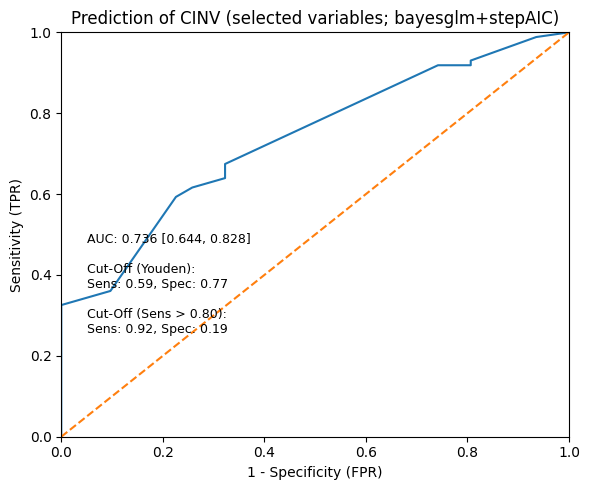

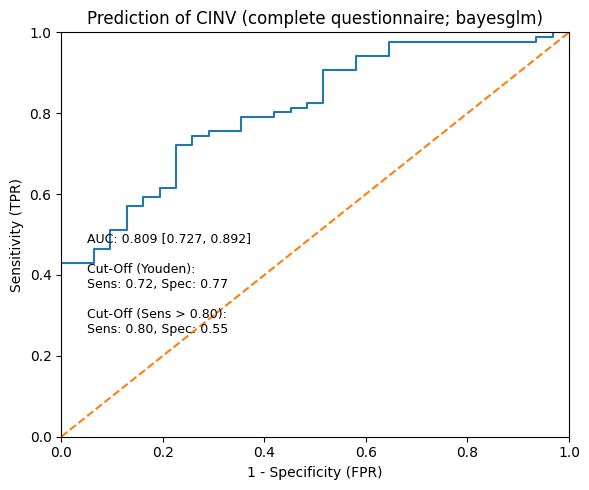

In [11]:
# Use the EXACT R-predicted probabilities
y = pt_q_cc["CINV_binary"].values

plot_roc_with_annotations(
    y_true=y,
    prob=np.array(bayes_step_res["pred_step"]),
    title="Prediction of CINV (selected variables; bayesglm+stepAIC)",
    out_path=os.path.join(OUTPUT_DIR, "ROC_selected_variables.eps"),
    auc=bayes_step_res["auc_step"],
    ci=bayes_step_res["ci_step"],
    youden=bayes_step_res["youden_step"],
    sens80=bayes_step_res["sens80_step"],
)

plot_roc_with_annotations(
    y_true=y,
    prob=np.array(bayes_step_res["pred_full"]),
    title="Prediction of CINV (complete questionnaire; bayesglm)",
    out_path=os.path.join(OUTPUT_DIR, "ROC_complete_questionnaire.eps"),
    auc=bayes_step_res["auc_full"],
    ci=bayes_step_res["ci_full"],
    youden=bayes_step_res["youden_full"],
    sens80=bayes_step_res["sens80_full"],
)

### Interpretation: Prediction of CINV (selected variables; bayesglm + stepAIC)
This ROC curve summarizes the discriminative ability of the reduced four-variable model selected by Bayesian logistic regression combined with stepAIC. The model includes Migraene, Uebelkeit_Medikament, Uebelkeit_Auto, and emetog_pot_max. The area under the curve (AUC) is 0.736 with a 95% confidence interval of 0.644 to 0.828. This indicates moderate discrimination. In practical terms, if we randomly select one patient who developed CINV and one who did not, the model will assign a higher predicted probability to the CINV patient in approximately 74% of such pairs. The confidence interval shows some uncertainty due to the modest sample size but clearly exceeds 0.5, meaning performance is meaningfully better than chance.

Two clinically relevant cut-off strategies are illustrated. Using the Youden criterion, which maximizes the sum of sensitivity and specificity, the model achieves a sensitivity of 0.59 and a specificity of 0.77. This means that under this threshold, about 59% of true CINV cases are correctly identified, while 77% of non-cases are correctly classified. This cut-off balances false negatives and false positives and may be reasonable when both types of errors are considered similarly important.

When forcing a sensitivity above 0.80, the trade-off becomes more extreme. At this threshold, sensitivity increases to 0.92, meaning most CINV cases are detected, but specificity drops to 0.19. In other words, almost all high-risk patients are captured, but many low-risk patients are falsely classified as high risk. This reflects the typical tension between sensitivity and specificity: in order to miss very few CINV cases, one must accept a high false-positive rate.

Overall, the reduced model shows moderate discriminative performance with clear and interpretable trade-offs between sensitivity and specificity. It is relatively parsimonious and may therefore be more robust for external validation, even though its in-sample AUC is lower than that of the full model.

### Interpretation: Prediction of CINV (complete questionnaire; bayesglm)
This ROC curve represents the full Bayesian logistic regression model including all questionnaire items. The AUC is 0.809 with a 95% confidence interval of 0.727 to 0.892, indicating good discrimination within the development sample. Compared to the reduced stepwise model, the full model has a higher AUC, meaning it separates patients with and without CINV more effectively when evaluated on the same data used for model fitting.

Using the Youden-based threshold, the full model achieves a sensitivity of 0.72 and a specificity of 0.77. This is a more balanced performance than the reduced model at its Youden cut-off, with improved sensitivity while maintaining the same specificity. At the alternative threshold enforcing sensitivity above 0.80, the model reaches a sensitivity of 0.80 and a specificity of 0.55. Compared to the reduced model, the loss in specificity under high-sensitivity conditions is less extreme, indicating that the full model can maintain better discrimination across a broader range of thresholds.

However, it is important to interpret this higher AUC cautiously. Because the full model includes many predictors relative to the sample size, it is more susceptible to overfitting. The improved apparent discrimination may partly reflect fitting to noise in this specific dataset. Therefore, while the full model performs better in-sample, it may not necessarily generalize better to an external validation cohort.

In summary, the full model demonstrates stronger apparent discrimination and a more favorable sensitivity–specificity trade-off across thresholds, but at the cost of greater complexity and potentially higher overfitting risk. The reduced model provides more parsimonious prediction with moderate discrimination, which may be advantageous when prioritizing interpretability and robustness for external validation.

In [12]:
# ============================================
# 2) Separation check: Uebelkeit_Auto x CINV_binary
# ============================================
tab = pd.crosstab(pt_q_cc["Uebelkeit_Auto"], pt_q_cc["CINV_binary"])
print(tab)

CINV_binary      0   1
Uebelkeit_Auto        
1                0  14
2               31  72


The cross-tabulation of Uebelkeit_Auto with CINV_binary reveals a clear pattern of quasi-complete separation in the data. Among patients with Uebelkeit_Auto coded as “1”, none developed CINV in the dataset, while 14 patients did. In contrast, among patients coded as “2”, 31 did not develop CINV and 72 did. This means that one category of the predictor perfectly predicts the absence of the outcome in this sample.

From a statistical perspective, this is highly relevant. In standard maximum likelihood logistic regression, such separation can lead to unstable or extremely large regression coefficients, because the model attempts to assign infinite log-odds to perfectly separating categories. This is precisely why the Bayesian logistic regression (bayesglm) was used in the modeling steps: it introduces weakly informative priors that regularize the coefficients and prevent numerical explosion.

Substantively, this table suggests that nausea in a car is strongly associated with CINV risk in this cohort. However, because the separation is based on a relatively small number of observations (14 cases in one category), this pattern may be sample-specific. Perfect or near-perfect separation in small datasets often inflates apparent predictive importance and increases the risk of overfitting.

Therefore, Uebelkeit_Auto appears to be a very strong predictor in the development sample, but its stability and effect size should be interpreted cautiously and ideally confirmed in an external validation cohort.

In [13]:
# ============================================
# 3) Ridge logistic (stable) + ROC summaries
# ============================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from statsmodels.stats.proportion import proportion_confint
import numpy as np

In [14]:
# Helper function to compute Youden and Sens>0.80 points from ROC curve
def roc_summary(y_true, prob):
    fpr, tpr, thr = roc_curve(y_true, prob)
    auc = roc_auc_score(y_true, prob)

    # Youden J (max sens + spec - 1) == max(tpr - fpr)
    J = tpr - fpr
    j_idx = int(np.argmax(J))
    youden = {
        "threshold": float(thr[j_idx]),
        "sensitivity": float(tpr[j_idx]),
        "specificity": float(1 - fpr[j_idx]),
        "auc": float(auc),
    }

    # "sens > 0.80": choose the point with sensitivity closest to 0.80 from above
    sens80 = None
    idxs = np.where(tpr >= 0.80)[0]
    if len(idxs) > 0:
        # closest from above = minimal tpr among those >= 0.80
        i = int(idxs[np.argmin(tpr[idxs])])
        sens80 = {
            "threshold": float(thr[i]),
            "sensitivity": float(tpr[i]),
            "specificity": float(1 - fpr[i]),
            "auc": float(auc),
        }

    return youden, sens80, auc

In [15]:
# Function
def sensitivity_ci(y_true, prob, threshold, alpha=0.05):
    """
    Compute sensitivity and exact (Clopper–Pearson) 95% CI
    """
    # Binary predictions at chosen threshold
    y_pred = (prob >= threshold).astype(int)

    # True positives and number of actual positives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    n_pos = np.sum(y_true == 1)

    sens = tp / n_pos

    # Exact binomial CI
    ci_low, ci_high = proportion_confint(
        count=tp,
        nobs=n_pos,
        alpha=alpha,
        method="beta"
    )

    return {
        "tp": int(tp),
        "n_pos": int(n_pos),
        "sensitivity": float(sens),
        "ci_low": float(ci_low),
        "ci_high": float(ci_high)
    }

In [16]:
# Define feature matrices
X_all = pt_q_cc.drop(columns=["CINV_binary"]).copy()
step_vars = bayes_step_res["step_terms"]
X_step = pt_q_cc[step_vars].copy()

In [17]:
# Full model ridge
ridge_full = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=5000))
])
ridge_full.fit(X_all, y)
prob_full = ridge_full.predict_proba(X_all)[:, 1]
youden_f, sens80_f, auc_f = roc_summary(y, prob_full)

print("\nFULL ridge AUC:", auc_f)
print("Youden:", youden_f)
print("Sens>=0.80:", sens80_f)


FULL ridge AUC: 0.8117029257314328
Youden: {'threshold': 0.7168068280692179, 'sensitivity': 0.7209302325581395, 'specificity': 0.7741935483870968, 'auc': 0.8117029257314328}
Sens>=0.80: {'threshold': 0.625837174019732, 'sensitivity': 0.8023255813953488, 'specificity': 0.5806451612903225, 'auc': 0.8117029257314328}


In [18]:
# Sensitivity CI for FULL ridge at ≥0.80 threshold
sens80_full_ci = sensitivity_ci(
    y_true=y,
    prob=prob_full,
    threshold=sens80_f["threshold"]
)

print("\nFULL ridge Sensitivity (≥0.80 threshold):")
print(sens80_full_ci)



FULL ridge Sensitivity (≥0.80 threshold):
{'tp': 69, 'n_pos': 86, 'sensitivity': 0.8023255813953488, 'ci_low': 0.7024785546703902, 'ci_high': 0.8804222641420971}


The ridge logistic regression model includes all questionnaire items and applies L2 regularization to stabilize coefficient estimates and reduce overfitting. Unlike stepwise selection, ridge does not remove variables from the model but instead shrinks all coefficients toward zero. This is particularly useful in settings with many correlated predictors and a relatively small sample size, as in this dataset.

The apparent discrimination of the full ridge model is reflected by an AUC of 0.812. This indicates good in-sample ability to distinguish between patients with and without CINV. In practical terms, the model assigns a higher predicted probability to a randomly chosen CINV case than to a non-case in approximately 81% of comparisons. This AUC is very similar to that observed for the full Bayesian logistic model, suggesting that regularization does not meaningfully reduce apparent discriminative performance in this dataset.

At the Youden-optimal threshold (probability ≈ 0.717), the model achieves a sensitivity of 0.72 and a specificity of 0.77. This represents a balanced classification rule: roughly 72% of patients who develop CINV are correctly identified, and 77% of patients without CINV are correctly classified as low risk. This threshold maximizes the combined true positive and true negative rates.

When enforcing a sensitivity of at least 0.80, the threshold shifts to approximately 0.626. Under this criterion, sensitivity increases to 0.80, meaning most CINV cases are detected, but specificity decreases to 0.58. In this scenario, more low-risk patients are falsely classified as high risk. This illustrates the typical trade-off in clinical prediction: prioritizing detection of true cases inevitably increases false positives.

Overall, the full ridge model shows strong apparent discrimination and stable behavior under different threshold strategies. Because ridge regularization reduces coefficient variance without eliminating predictors, it provides a more conservative and potentially more generalizable alternative to the full unpenalized model while maintaining similar in-sample AUC.

In [19]:
# Stepwise ridge model
ridge_step = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=5000))
])
ridge_step.fit(X_step, y)
prob_step = ridge_step.predict_proba(X_step)[:, 1]
youden_s, sens80_s, auc_s = roc_summary(y, prob_step)

print("\nSTEPWISE ridge AUC:", auc_s)
print("Youden:", youden_s)
print("Sens>=0.80:", sens80_s)


STEPWISE ridge AUC: 0.735933983495874
Youden: {'threshold': 0.7692767702244595, 'sensitivity': 0.5930232558139535, 'specificity': 0.7741935483870968, 'auc': 0.735933983495874}
Sens>=0.80: {'threshold': 0.6359219696623478, 'sensitivity': 0.9186046511627907, 'specificity': 0.25806451612903225, 'auc': 0.735933983495874}


In [20]:
# Sensitivity CI for STEPWISE ridge at ≥0.80 threshold
sens80_step_ci = sensitivity_ci(
    y_true=y,
    prob=prob_step,
    threshold=sens80_s["threshold"]
)

print("\nSTEPWISE ridge Sensitivity (≥0.80 threshold):")
print(sens80_step_ci)



STEPWISE ridge Sensitivity (≥0.80 threshold):
{'tp': 79, 'n_pos': 86, 'sensitivity': 0.9186046511627907, 'ci_low': 0.8394603286669187, 'ci_high': 0.9666475709698241}


The stepwise ridge model applies L2-regularized logistic regression to the reduced set of predictors selected by the Bayesian stepAIC procedure. In contrast to the full ridge model, this version includes only the four selected questionnaire items but still applies shrinkage to stabilize the coefficients.

The apparent AUC of this model is 0.736, which is identical to the AUC observed for the Bayesian stepwise model. This is expected because the variable set is the same and the regularization strength (C = 1.0) is relatively mild. The AUC indicates moderate discrimination: the model correctly ranks a randomly chosen CINV case above a non-case in approximately 74% of pairwise comparisons.

At the Youden-optimal threshold (probability ≈ 0.769), sensitivity is 0.59 and specificity is 0.77. This means that about 59% of true CINV cases are correctly detected, while 77% of non-cases are correctly classified as low risk. Compared to the full ridge model, sensitivity is lower at this balanced threshold, while specificity remains similar. This reflects the loss of predictive information when reducing the model to four variables.

When enforcing a sensitivity of at least 0.80, the threshold decreases to approximately 0.636. Under this setting, sensitivity increases substantially to 0.92, meaning nearly all CINV cases are identified. However, specificity drops sharply to 0.26, indicating that a large proportion of non-CINV patients would be incorrectly classified as high risk. This trade-off is considerably more extreme than in the full ridge model, highlighting that the reduced model has less flexibility to maintain specificity when high sensitivity is required.

Overall, the stepwise ridge model demonstrates moderate discriminative performance and behaves similarly to the original Bayesian stepwise model. While it is more parsimonious and easier to interpret than the full model, it sacrifices some discriminative strength and shows a more pronounced sensitivity–specificity trade-off at clinically stringent thresholds.

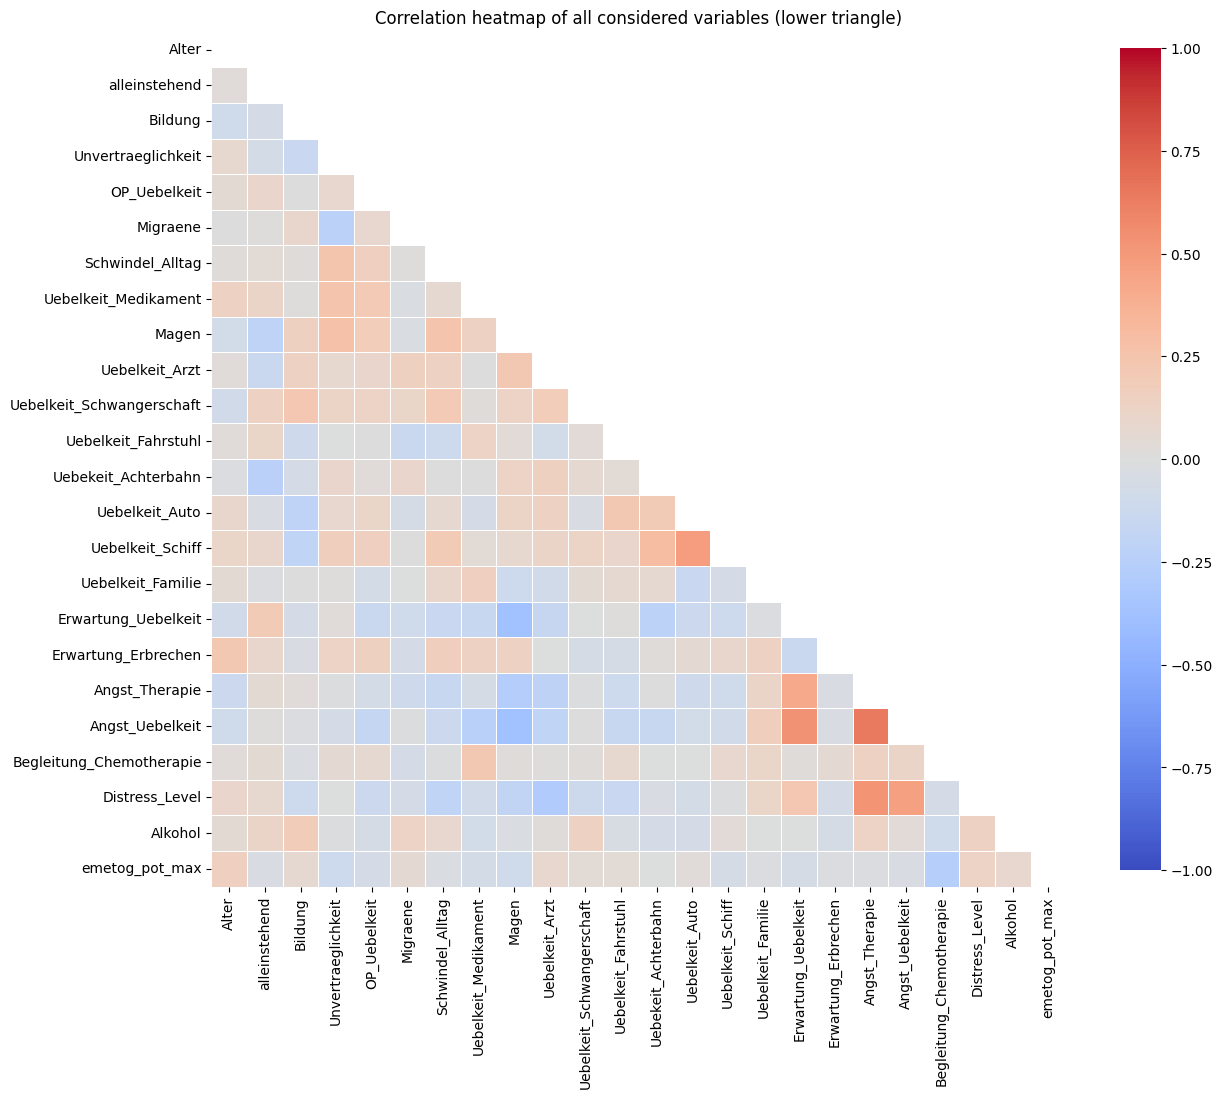

In [21]:
# ============================================
# 4) Correlation heatmap
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

X_corr = pt_q_cc.drop(columns=["CINV_binary"])
corr = X_corr.corr().round(3)

mask = np.triu(np.ones_like(corr, dtype=bool))  # mask upper triangle

# Only annotate unmasked cells (lower triangle)
annot = corr.where(~mask)  # upper triangle -> NaN

plt.figure(figsize=(13, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=annot,
    fmt=".2f",
    square=True,
    cmap="coolwarm",      # diverging colormap
    vmin=-1,            # lower bound
    vmax=1,             # upper bound
    center=0,             # center at zero
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)
plt.title("Correlation heatmap of all considered variables (lower triangle)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "correlation_heatmap.eps"), dpi=600)
plt.show()

The correlation heatmap displays the pairwise Pearson correlations among all questionnaire variables included in the analysis (excluding the binary outcome). Only the lower triangle is shown to improve readability. The color intensity reflects the strength and direction of the correlation: warmer colors indicate stronger positive associations, while darker tones indicate negative associations.

Overall, the majority of correlations are small to moderate in magnitude. This suggests that although several questionnaire items are conceptually related, they are not redundant to the degree that would indicate severe multicollinearity. In other words, most items capture partially overlapping but still distinct aspects of nausea susceptibility, anxiety, expectations, or clinical context.

Some expected clusters are visible. Items related to different forms of nausea (e.g., nausea in car, ship, rollercoaster, elevator) show moderate positive correlations with each other, reflecting a shared underlying construct of motion-related or situational nausea sensitivity. Similarly, psychological variables such as Erwartung_Uebelkeit, Erwartung_Erbrechen, Angst_Therapie, Angst_Uebelkeit, and Distress_Level tend to correlate positively, suggesting that anticipatory anxiety and distress form a coherent psychological domain.

Importantly, no extremely high correlations (e.g., above 0.8 or 0.9) are observed. This indicates that the predictors do not appear to be near-duplicates of each other. Therefore, multicollinearity is unlikely to be the primary driver of instability in the logistic models. Instead, any instability observed earlier is more plausibly explained by the relatively small sample size and partial separation rather than by excessive redundancy among predictors.

In summary, the correlation structure suggests the presence of meaningful conceptual groupings (e.g., motion-related nausea, psychological distress), but without evidence of critical multicollinearity that would invalidate regression modeling. This supports the decision to use regularized methods (such as ridge or LASSO) primarily for shrinkage and generalization rather than as a corrective measure for extreme predictor redundancy.

In [22]:
# ============================================
# 5) PCA (5 PCs) + loadings (abs>=0.4)
# ============================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

X = pt_q_cc.drop(columns=["CINV_binary"])
X_std = StandardScaler().fit_transform(X.values)

pca = PCA(n_components=5, random_state=0)
PC_scores = pca.fit_transform(X_std)

In [23]:
# var-PC correlations (FactoMineR var$cor analogue):
# correlation between standardized original variables and PC scores
var_cor = np.corrcoef(X_std.T, PC_scores.T)[:X.shape[1], X.shape[1]:]
var_cor_df = pd.DataFrame(var_cor, index=X.columns, columns=[f"PC{i}" for i in range(1,6)])

# filter abs>=0.4 like colleague
var_cor_filt = var_cor_df.where(var_cor_df.abs() >= 0.4).dropna(how="all")
print(var_cor_filt)

                                PC1       PC2       PC3       PC4       PC5
Alter                           NaN       NaN       NaN       NaN  0.540523
alleinstehend                   NaN       NaN       NaN       NaN  0.565240
Bildung                         NaN  0.505653 -0.458288       NaN       NaN
Unvertraeglichkeit              NaN -0.468352       NaN       NaN       NaN
Magen                     -0.608132       NaN       NaN       NaN       NaN
Uebelkeit_Arzt            -0.441067       NaN       NaN       NaN       NaN
Uebelkeit_Schwangerschaft       NaN       NaN -0.474665  0.417309       NaN
Uebelkeit_Auto                  NaN       NaN  0.476864       NaN       NaN
Uebelkeit_Schiff                NaN -0.480949       NaN  0.503655       NaN
Erwartung_Uebelkeit        0.646325       NaN       NaN       NaN       NaN
Angst_Therapie             0.688252       NaN       NaN       NaN       NaN
Angst_Uebelkeit            0.760122       NaN       NaN       NaN       NaN
Distress_Lev

Principal component analysis (PCA) was performed on the standardized questionnaire variables to explore the latent structure underlying the items and to assess whether broader dimensions could summarize the information contained in the individual predictors. Five principal components were extracted, and only variable loadings with an absolute correlation of at least 0.40 with a component were displayed, following the colleague’s approach.

Principal component analysis (PCA) was performed on the standardized questionnaire variables to explore the latent structure underlying the items and to assess whether broader dimensions could summarize the information contained in the individual predictors. Five principal components were extracted, and only variable loadings with an absolute correlation of at least 0.40 with a component were displayed, following the colleague’s approach.

The second principal component (PC2) is defined mainly by Bildung (positive loading) and Unvertraeglichkeit and Uebelkeit_Schiff (negative loadings). This pattern may reflect a socio-demographic or general susceptibility dimension, although the interpretation is less straightforward and may combine educational level with certain nausea-related sensitivities.

The third principal component (PC3) loads on Uebelkeit_Auto and Uebelkeit_Schwangerschaft (with opposite signs for some items). This suggests that PC3 captures a specific motion- or situation-related nausea tendency. It reflects variability in how patients respond to distinct nausea-triggering contexts.

The fourth principal component (PC4) shows meaningful loadings for Uebelkeit_Schiff, Uebelkeit_Schwangerschaft, and Alkohol. This may represent another context-dependent nausea susceptibility pattern, possibly linked to vestibular or physiological sensitivity across different exposures.

The fifth principal component (PC5) is associated with Alter, alleinstehend, and emetog_pot_max. This suggests a dimension that combines demographic characteristics and treatment-related risk (emetogenic potential), potentially reflecting a more clinical or structural risk axis rather than subjective symptom vulnerability.

Overall, the PCA indicates that the questionnaire items cluster into interpretable domains, particularly a strong psychological distress/expectation component (PC1) and several nausea-susceptibility components related to different contexts. However, these components are statistical constructs and do not necessarily correspond to clinically validated scales. Their value lies in illustrating that the predictors are not randomly distributed but reflect underlying latent structures that may influence CINV risk.

In [24]:
# ============================================
# OR10) Export PCA variable–PC correlations (abs >= 0.4)
# ============================================
or10_full_path = os.path.join(OUTPUT_DIR, "OnlineResource10_PCA_var_pc_cor_FULL.csv")
var_cor_df.to_csv(or10_full_path, index=True)
print(f"[Saved] Online Resource 10 (full) -> {or10_full_path}")

[Saved] Online Resource 10 (full) -> /Users/stevenschepanski/Documents/04_ANALYSIS/InstitutBiometrie/EMRISK/4_Auswertung/4.1_Programmcode/Steven/Output/OnlineResource10_PCA_var_pc_cor_FULL.csv


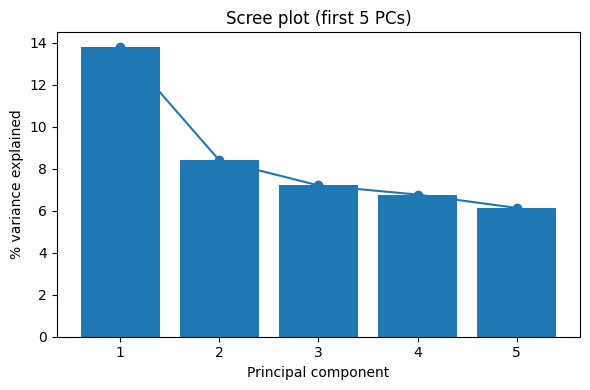

In [25]:
# Scree plot of explained variance
explained_pct = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(6,4))
plt.bar(range(1,6), explained_pct)
plt.plot(range(1,6), explained_pct, marker="o")
plt.xticks(range(1,6))
plt.ylabel("% variance explained")
plt.xlabel("Principal component")
plt.title("Scree plot (first 5 PCs)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "PCA_scree.eps"), dpi=600)
plt.show()


The scree plot shows the proportion of total variance explained by each of the first five principal components. The first component accounts for approximately 14% of the total variance, the second for about 8–9%, and each of the remaining components explains roughly 6–7% individually. There is a noticeable drop from the first to the second component, but beyond that, the curve flattens considerably.

This pattern indicates that there is no single dominant latent dimension underlying the questionnaire. Although the first principal component captures the largest share of variance, it still explains only a modest proportion of the overall variability. The gradual decline across components and the absence of a sharp “elbow” suggest that the information in the questionnaire is distributed across multiple dimensions rather than being driven by one or two strong underlying factors.

In practical terms, this means that dimensionality reduction through PCA does not lead to a dramatic simplification of the predictor space. The questionnaire appears to capture several partially independent constructs, each contributing a relatively small portion of total variance. Therefore, replacing the original items with only a small number of principal components may result in loss of potentially relevant predictive information.

Overall, the scree plot supports the interpretation that CINV risk is likely influenced by multiple domains, such as psychological distress, situational nausea susceptibility, and clinical risk factors, rather than a single overarching latent factor.

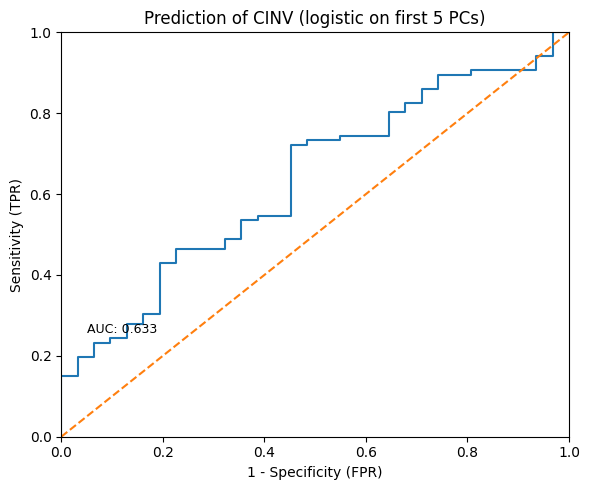

In [26]:
# Logistic regression on PCs (glm on PC scores analogue)
from sklearn.linear_model import LogisticRegression

pc_model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=5000)
pc_model.fit(PC_scores, y)
pc_prob = pc_model.predict_proba(PC_scores)[:, 1]

plot_roc_with_annotations(
    y_true=y,
    prob=pc_prob,
    title="Prediction of CINV (logistic on first 5 PCs)",
    out_path=os.path.join(OUTPUT_DIR, "ROC_pca_logistic.eps"),
)

### Interpretation: Prediction of CINV (logistic regression on first 5 principal components)
This ROC curve evaluates a logistic regression model that uses the first five principal components (PCs) instead of the original questionnaire items as predictors. These components summarize the overall structure of the questionnaire into five uncorrelated dimensions. The goal of this approach is dimensionality reduction: instead of modeling many individual items, the analysis uses broader latent constructs extracted by PCA.

The resulting AUC is 0.633, which indicates weak to modest discrimination. In practical terms, the model correctly assigns a higher predicted probability to a randomly selected CINV patient than to a non-CINV patient in approximately 63% of cases. While this is better than random classification (AUC = 0.5), it is clearly inferior to the performance of the stepwise item-based model (AUC ≈ 0.736) and especially the full questionnaire model (AUC ≈ 0.81).

This result highlights an important methodological point: principal components are derived to maximize explained variance in the predictors, not to maximize association with the outcome. The components capture the main structure of the questionnaire, but that structure does not necessarily align with the most predictive features for CINV. In other words, PCA is unsupervised, whereas prediction of CINV is a supervised task.

The ROC curve therefore suggests that compressing the questionnaire into five latent dimensions leads to a loss of outcome-relevant information. Although PCA is useful for understanding the internal structure of the questionnaire and reducing collinearity, it does not improve predictive discrimination in this dataset.

Overall, the PCA-based model demonstrates that the predictive signal for CINV is not sufficiently captured by the first five general components. For this specific prediction task, retaining selected individual questionnaire items provides substantially better discrimination.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


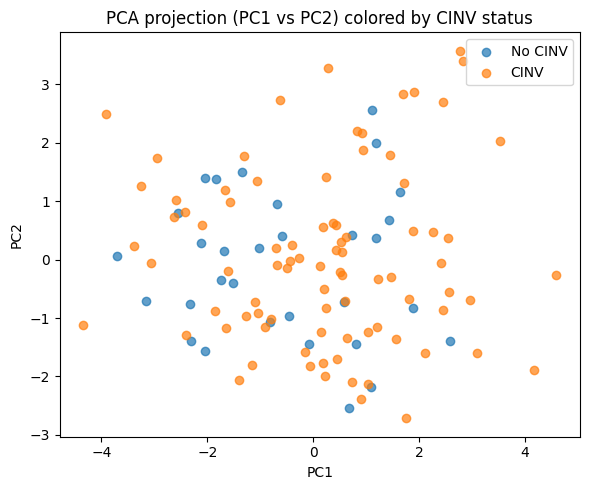

In [27]:
# ============================================
# PCA scatter plot (PC1 vs PC2), colored by CINV
# ============================================

plt.figure(figsize=(6,5))

for cls, label in [(0, "No CINV"), (1, "CINV")]:
    idx = (y == cls)
    plt.scatter(
        PC_scores[idx, 0],
        PC_scores[idx, 1],
        label=label,
        alpha=0.7
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection (PC1 vs PC2) colored by CINV status")
plt.legend()
plt.tight_layout()

# Save as EPS in final output folder
plt.savefig(
    os.path.join(OUTPUT_DIR, "PCA_PC1_PC2_by_CINV.eps"),
    format="eps",
    bbox_inches="tight"
)

plt.show()

The PCA projection of the first two principal components shows substantial overlap between patients with and without CINV. There is no clear clustering or visual boundary separating the two groups in the PC1–PC2 space. Both CINV and non-CINV cases are distributed across the full range of the first two components, indicating that the dominant sources of variance in the questionnaire are not primarily driven by CINV status.

This is an important finding. Principal Component Analysis identifies directions of maximal overall variance in the predictors, independent of the outcome. The fact that CINV cases do not form a distinct cluster suggests that the overall latent structure of the questionnaire does not naturally separate patients by outcome. In other words, CINV risk is not explained by a single dominant underlying dimension captured by PC1 or PC2.

This aligns with your earlier results showing that logistic regression on the first five principal components achieved only modest discrimination (AUC ≈ 0.63). The PCA visualization reinforces that the predictive signal is not concentrated in a global latent construct but rather appears to arise from specific questionnaire items.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


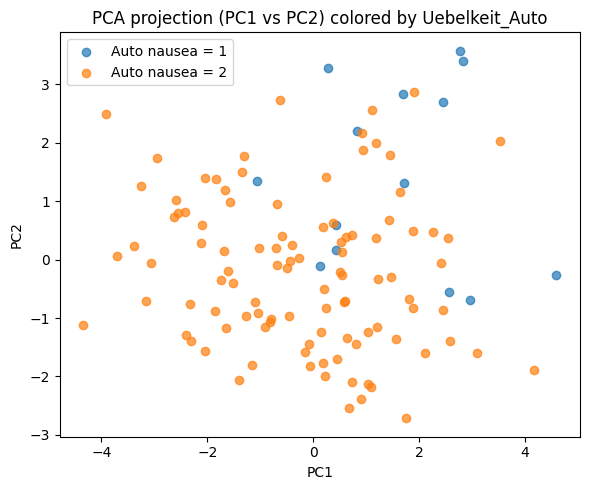

In [28]:
# ============================================
# PCA scatter plot colored by Uebelkeit_Auto
# ============================================

auto = pt_q_cc["Uebelkeit_Auto"].values

plt.figure(figsize=(6,5))

for val, label in [(1, "Auto nausea = 1"), (2, "Auto nausea = 2")]:
    idx = (auto == val)
    plt.scatter(
        PC_scores[idx, 0],
        PC_scores[idx, 1],
        label=label,
        alpha=0.7
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection (PC1 vs PC2) colored by Uebelkeit_Auto")
plt.legend()
plt.tight_layout()

# Save as EPS in final output folder
plt.savefig(
    os.path.join(OUTPUT_DIR, "PCA_PC1_PC2_by_Uebelkeit_Auto.eps"),
    format="eps",
    bbox_inches="tight"
)

plt.show()


When projecting the data onto the first two principal components and coloring by Uebelkeit_Auto, there is again no clear geometric separation between the two categories. The points representing “Auto nausea = 1” and “Auto nausea = 2” are largely intermingled across the PC1–PC2 space, without forming distinct clusters.

This is highly informative. Although the cross-tabulation showed quasi-complete separation with respect to CINV, this separation does not appear to reflect a dominant global pattern in the overall questionnaire structure. Instead, Uebelkeit_Auto seems to act as a strong, specific predictor rather than representing a broader latent dimension captured by PCA.

In practical terms, this means that the predictive power of Uebelkeit_Auto is not due to it defining a separate subgroup in the multidimensional questionnaire space. Rather, it contributes a targeted signal directly associated with the outcome. This supports the idea that certain single items may carry disproportionate predictive value, even if they do not define an overall structural cluster in the data.

From a modeling perspective, this reinforces the importance of supervised methods (logistic regression, penalization, stability selection) over unsupervised dimensionality reduction. PCA identifies variance structure, not outcome separation. The absence of visual clustering in PCA space does not contradict the strong predictive association seen in the logistic models—it simply indicates that the signal is not aligned with the major axes of overall variance.

Conceptually, this also strengthens your earlier caution: the strong predictive behavior of Uebelkeit_Auto is likely a specific association within this sample, rather than reflecting a large underlying latent construct. This makes external validation particularly important.

In [29]:
# ============================================
# 6) Stability Selection (Elastic Net, 1000 bootstraps)
# ============================================
from sklearn.linear_model import LogisticRegressionCV
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.utils import resample
import matplotlib.pyplot as plt

np.random.seed(42)

X = pt_q_cc.drop(columns=["CINV_binary"]).values
y = pt_q_cc["CINV_binary"].values
feature_names = pt_q_cc.drop(columns=["CINV_binary"]).columns.tolist()

B = 1000
selection_counts = np.zeros(len(feature_names))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)

    for b in range(B):
        X_boot, y_boot = resample(X, y, replace=True)

        enet = LogisticRegressionCV(
            Cs=10,
            cv=5,
            penalty="elasticnet",
            solver="saga",
            l1_ratios=[0.5],
            max_iter=5000,
            scoring="roc_auc"
        )
        enet.fit(X_boot, y_boot)

        coefs = enet.coef_.flatten()
        selection_counts += (np.abs(coefs) > 1e-6)

selection_freq = selection_counts / B

stability_df = pd.DataFrame({
    "variable": feature_names,
    "selection_frequency": selection_freq
}).sort_values("selection_frequency", ascending=False)

print(stability_df)

                     variable  selection_frequency
21             Distress_Level                0.987
13             Uebelkeit_Auto                0.970
5                    Migraene                0.967
23             emetog_pot_max                0.958
0                       Alter                0.947
2                     Bildung                0.944
18             Angst_Therapie                0.927
20   Begleitung_Chemotherapie                0.919
16        Erwartung_Uebelkeit                0.917
19            Angst_Uebelkeit                0.917
22                    Alkohol                0.905
7        Uebelkeit_Medikament                0.886
4                OP_Uebelkeit                0.884
17        Erwartung_Erbrechen                0.880
10  Uebelkeit_Schwangerschaft                0.875
8                       Magen                0.868
12        Uebekeit_Achterbahn                0.864
6            Schwindel_Alltag                0.864
14           Uebelkeit_Schiff  

Stability selection was performed using elastic net logistic regression with 1000 bootstrap resamples. In each bootstrap sample, an internally cross-validated elastic net model was fitted, and we recorded whether each variable received a non-zero coefficient. The selection frequency therefore represents the proportion of bootstrap samples in which a given variable was selected by the penalized model.

The results show that several variables were selected in a very high proportion of bootstrap samples. Distress_Level (98.7%), Uebelkeit_Auto (97.0%), Migraene (96.7%), and emetog_pot_max (95.8%) appear particularly stable. These variables were selected in almost every resampled dataset, suggesting that their predictive contribution is not dependent on a specific random sample configuration. This strongly supports their robustness as predictors of CINV risk in this cohort.

Interestingly, a large number of additional variables also show high selection frequencies, many above 0.85. This indicates that under elastic net regularization with moderate mixing (l1_ratio = 0.5), the model tends to retain many predictors rather than aggressively excluding them. This behavior reflects both the relatively small sample size and the correlated structure of the questionnaire items. Elastic net is designed to retain groups of correlated variables together rather than selecting only one representative, which explains why many nausea-related and psychological variables show high selection frequencies.

The absence of sharply low selection frequencies suggests that the predictive signal is distributed across multiple questionnaire domains. Rather than a small set of isolated predictors dominating the model, there appears to be a broader multivariate pattern contributing to CINV risk.

From a modeling perspective, the most important insight is that the core predictors previously identified through LASSO and stepwise selection, particularly Uebelkeit_Auto, Migraene, emetog_pot_max, and Distress_Level, also emerge as highly stable under bootstrap-based elastic net selection. This convergence across methods strengthens confidence that these variables represent genuinely informative predictors rather than artifacts of a single selection procedure.

At the same time, the generally high selection frequencies across many items underscore the limitations imposed by the sample size. With 117 patients and 86 events, the data support moderate complexity but do not strongly discriminate between many correlated predictors. Therefore, external validation will be essential to determine which predictors retain their importance in an independent cohort.

In [30]:
# ============================================
# OR9) Export stability selection frequencies
# ============================================
or9_path = os.path.join(OUTPUT_DIR, "OnlineResource9_stability_selection_frequencies.csv")
stability_df.to_csv(or9_path, index=False)
print(f"[Saved] Online Resource 9 -> {or9_path}")


[Saved] Online Resource 9 -> /Users/stevenschepanski/Documents/04_ANALYSIS/InstitutBiometrie/EMRISK/4_Auswertung/4.1_Programmcode/Steven/Output/OnlineResource9_stability_selection_frequencies.csv


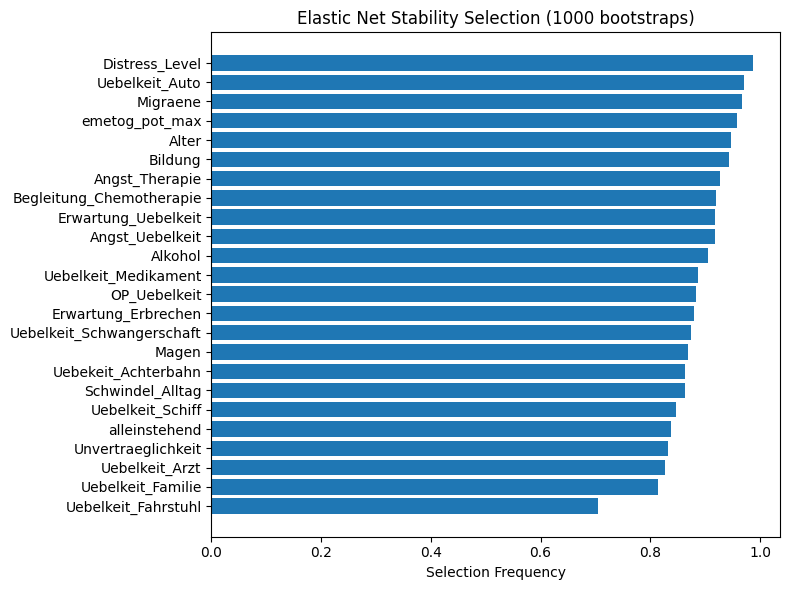

In [31]:
# Plot
plt.figure(figsize=(8,6))
plt.barh(stability_df["variable"], stability_df["selection_frequency"])
plt.gca().invert_yaxis()
plt.xlabel("Selection Frequency")
plt.title("Elastic Net Stability Selection (1000 bootstraps)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "stability_selection.eps"), dpi=600)
plt.show()

This figure visualizes the selection frequency of each questionnaire variable across 1000 bootstrap samples using elastic net logistic regression. The horizontal axis represents the proportion of bootstrap samples in which a variable received a non-zero coefficient. Values close to 1 indicate that the variable was selected in nearly every resampled dataset, whereas lower values indicate less stable selection.

Several variables stand out with extremely high selection frequencies. In particular, 'Distress_Level', 'Uebelkeit_Auto', 'Migraene', and 'emetog_pot_max' were selected in **more than 95%** of bootstrap samples. This indicates that their predictive contribution is highly stable and does not depend on a specific random sampling configuration. These variables consistently carry predictive signal across repeated perturbations of the data.

Interestingly, most other variables also show relatively high selection frequencies, many above 0.80. This reflects the behavior of elastic net regularization, which tends to retain groups of correlated predictors rather than excluding all but one. Because many questionnaire items capture related aspects of **nausea susceptibility** or **psychological distress**, the model frequently selects several of them together. In a small dataset with moderate intercorrelations, elastic net therefore favors broader inclusion rather than very sparse solutions.

The relatively small spread in selection frequencies suggests that the predictive information is distributed across multiple domains rather than concentrated in only one or two dominant items. At the same time, the clear ranking of variables still provides useful insight. The variables at the top of the plot appear to represent the most robust predictors in this cohort.

From a methodological perspective, this stability analysis strengthens confidence in the core predictors previously identified by LASSO and stepwise selection. The convergence of results across multiple selection strategies suggests that certain items, particularly 'Uebelkeit_Auto', 'Migraene', 'emetog_pot_max', and 'Distress_Level—are' not merely artifacts of one modeling technique. However, the overall high selection frequencies across many variables also emphasize that external validation will be crucial to determine which predictors retain their importance in an independent cohort.

In [32]:
# ============================================
# 7) Bootstrap Optimism-Corrected AUC
# ============================================
from sklearn.metrics import roc_auc_score

In [33]:
# Helper function for bootstrap optimism correction of AUC
def bootstrap_optimism(model_builder, X, y, B=1000):
    apparent_model = model_builder()
    apparent_model.fit(X, y)
    apparent_pred = apparent_model.predict_proba(X)[:,1]
    apparent_auc = roc_auc_score(y, apparent_pred)

    optimism = []

    for b in range(B):
        X_boot, y_boot = resample(X, y, replace=True)

        model = model_builder()
        model.fit(X_boot, y_boot)

        auc_boot = roc_auc_score(y_boot, model.predict_proba(X_boot)[:,1])
        auc_test = roc_auc_score(y, model.predict_proba(X)[:,1])

        optimism.append(auc_boot - auc_test)

    optimism = np.mean(optimism)
    corrected_auc = apparent_auc - optimism

    return apparent_auc, corrected_auc

In [34]:
# Elastic net builder
def enet_builder():
    return LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        l1_ratio=0.5,
        C=1.0,
        max_iter=5000
    )

In [35]:
# Ridge builder (stepwise vars)
def ridge_builder():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=5000))
    ])

In [36]:
# Use the same X and y as before
X_step = pt_q_cc[step_vars].values

auc_app_enet, auc_corr_enet = bootstrap_optimism(enet_builder, X, y)
auc_app_ridge, auc_corr_ridge = bootstrap_optimism(ridge_builder, X_step, y)

print("Elastic Net AUC apparent:", auc_app_enet)
print("Elastic Net AUC corrected:", auc_corr_enet)

print("Ridge (step vars) AUC apparent:", auc_app_ridge)
print("Ridge (step vars) AUC corrected:", auc_corr_ridge)

Elastic Net AUC apparent: 0.7970742685671418
Elastic Net AUC corrected: 0.6350302436739094
Ridge (step vars) AUC apparent: 0.735933983495874
Ridge (step vars) AUC corrected: 0.7104804403911269


The bootstrap optimism-corrected AUC compares how well a model appears to perform on the data it was trained on (“apparent” AUC) versus an estimate of how well it is expected to perform on new, similar patients after correcting for overfitting (“optimism-corrected” AUC). The correction is necessary because any model-building procedure will look better when evaluated on the same data used to fit it, especially when variable selection or hyperparameter tuning is involved.

For the elastic net model, the apparent AUC is about 0.80, which would suggest good discrimination if taken at face value. However, after optimism correction the AUC drops substantially to about 0.64. This large decrease indicates strong overfitting. In other words, the elastic net model is exploiting patterns in this specific dataset that do not replicate reliably under resampling. This is not surprising in small samples when the model is allowed to tune regularization internally and potentially keep many correlated predictors. The combination of hyperparameter tuning and multivariable fitting can inflate apparent performance, but the bootstrap reveals that much of this apparent discrimination is optimistic.

For the ridge model fitted on the stepwise-selected variables, the apparent AUC is about 0.736 and the optimism-corrected AUC is about 0.710. The drop here is modest, which suggests substantially better generalizability than the elastic net approach in this setting. Conceptually, this makes sense because the ridge model is constrained to a small, predefined set of predictors (the stepwise-selected items), and ridge shrinkage stabilizes coefficient estimates in the presence of separation and small-sample noise. The optimism correction indicates that most of the observed discrimination is likely to carry over to a new sample from the same population.

Taken together, these results imply that the elastic net “looks good” in-sample but does not appear stable enough to rely on for prediction without external validation, whereas the ridge model on the reduced predictor set provides more conservative but more credible performance. If the goal is to define a set of questionnaire items that will generalize to another cohort, the ridge/selected-variable approach is currently more convincing based on internal validation.

In [37]:
# ============================================
# OR8) Export bootstrap optimism-corrected AUC table
# ============================================
or8_df = pd.DataFrame([
    {
        "Model": "Elastic net (l1_ratio=0.5, C=1.0)",
        "Apparent_AUC": float(auc_app_enet),
        "Optimism_corrected_AUC": float(auc_corr_enet),
        "Bootstrap_resamples_B": 1000
    },
    {
        "Model": "Ridge (restricted to 4 predictors; stepwise-selected)",
        "Apparent_AUC": float(auc_app_ridge),
        "Optimism_corrected_AUC": float(auc_corr_ridge),
        "Bootstrap_resamples_B": 1000
    }
])

or8_path = os.path.join(OUTPUT_DIR, "OnlineResource8_bootstrap_optimism_AUC.csv")
or8_df.to_csv(or8_path, index=False)
print(f"[Saved] Online Resource 8 -> {or8_path}")


[Saved] Online Resource 8 -> /Users/stevenschepanski/Documents/04_ANALYSIS/InstitutBiometrie/EMRISK/4_Auswertung/4.1_Programmcode/Steven/Output/OnlineResource8_bootstrap_optimism_AUC.csv


In [38]:
# ============================================
# 8) Calibration Analysis
# ============================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

# Use ridge_step as final model example
ridge_step.fit(X_step, y)
prob = ridge_step.predict_proba(X_step)[:, 1]

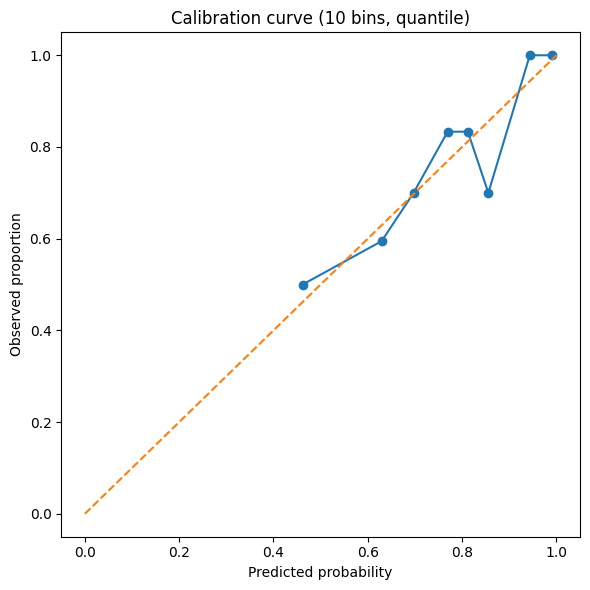

In [39]:
# Calibration curve
frac_pos, mean_pred = calibration_curve(y, prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed proportion")
plt.title("Calibration curve (10 bins, quantile)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "calibration_curve.eps"), dpi=600)
plt.show()

The calibration curve evaluates how well the predicted probabilities from the ridge model agree with the actually observed event frequencies. On the x-axis, the mean predicted probability within each decile (10 quantile-based bins) is shown, and on the y-axis the corresponding observed proportion of CINV is displayed. The dashed diagonal line represents perfect calibration, meaning that predicted risks and observed risks are identical.

In this plot, most points lie reasonably close to the diagonal, particularly in the mid-range of predicted probabilities. This suggests that, for patients with moderate predicted risk, the model’s probabilities are fairly well aligned with the true observed frequencies. In the higher-risk range, there is some deviation: one bin around predicted probabilities of roughly 0.85 appears to slightly overestimate risk (observed proportion lower than predicted), while the very highest-risk bin is again close to the ideal line. Given the relatively small sample size and the limited number of patients in extreme risk categories, some fluctuation in the upper range is expected.

Overall, the curve indicates acceptable calibration for the ridge model on the stepwise-selected variables. The model does not appear to show systematic and strong miscalibration (such as consistently overestimating or underestimating risk across the entire range). However, because this assessment is still based on the same dataset used for model development, the true calibration performance can only be confirmed in an independent validation cohort.

In [40]:
# Calibration intercept & slope
# Fit: y ~ a + b * logit(prob)
eps = 1e-6
p = np.clip(prob, eps, 1 - eps)
logit_p = np.log(p / (1 - p)).reshape(-1, 1)

cal_lr = LogisticRegression(penalty=None, solver="lbfgs", max_iter=5000)
cal_lr.fit(logit_p, y)

cal_intercept = float(cal_lr.intercept_[0])  # a
cal_slope = float(cal_lr.coef_[0][0])        # b

print("Calibration intercept (a):", cal_intercept)
print("Calibration slope (b):", cal_slope)

Calibration intercept (a): -0.12832911404497221
Calibration slope (b): 1.1643549620808902


The calibration intercept and slope provide a more formal and quantitative assessment of model calibration beyond the visual inspection of the calibration curve.

The calibration intercept is −0.13. In an ideally calibrated model, the intercept would be exactly 0. A negative intercept indicates that, on average, the model slightly overestimates the risk of CINV. In practical terms, the predicted probabilities are marginally too high across the sample. However, the deviation from zero is small, suggesting that the degree of systematic overprediction is modest.

The calibration slope is 1.16. For perfect calibration, the slope should be exactly 1. A slope greater than 1 typically indicates that the model predictions are somewhat too moderate, meaning that low risks are slightly overestimated and high risks slightly underestimated. In other words, the spread of predicted probabilities is not extreme enough relative to the true underlying risk. The fact that the slope is above 1 rather than below 1 is reassuring in the sense that it does not suggest classical overfitting, which would typically produce a slope below 1 in internal validation. However, because this slope is still estimated on the development data, it does not yet reflect true external performance.

Taken together, the calibration intercept and slope suggest that the ridge model based on the selected variables shows reasonably good calibration in the development dataset, with only minor systematic deviation. Nevertheless, proper assessment of calibration requires evaluation in an independent validation cohort, where overfitting and optimism can be more reliably detected.

In [41]:
# Brier score
brier = brier_score_loss(y, prob)
print("Brier score:", brier)

Brier score: 0.1688179799118656


The Brier score is 0.169. The Brier score measures the mean squared difference between the predicted probabilities and the observed outcomes. It ranges from 0 to 1, where lower values indicate better overall predictive performance. A value of 0 would represent perfect predictions, meaning that all predicted probabilities exactly match the observed outcomes.

In this dataset, the prevalence of CINV is approximately 86 out of 117 patients (around 74%). A naïve model that always predicts the overall event rate for every patient would already achieve a certain baseline Brier score. Compared to such a trivial model, a Brier score of 0.169 indicates that the ridge model provides meaningful probabilistic discrimination and improves upon a constant prediction.

Importantly, the Brier score reflects both discrimination and calibration. It rewards models that assign high probabilities to true events and low probabilities to non-events, while also penalizing poorly calibrated probabilities. In combination with the AUC and calibration slope/intercept, the Brier score supports the conclusion that the selected-variable ridge model achieves reasonable predictive accuracy in the development sample, although external validation remains essential to confirm its performance.

In [42]:
# ============================================
# 9) Sensitivity analysis:
#     Exclude patients with <3 antiemetics and re-fit FINAL model
#     (ridge logistic on the 4 selected predictors)
# ============================================

In [43]:
# ---- Helper: apply same preprocessing used above ----
def make_complete_cases(df, outcome_col="CINV_binary"):
    df = df.copy()
    df = df.replace({99: np.nan, 999: np.nan})

    if outcome_col not in df.columns:
        raise ValueError(f"{outcome_col} not found in dataframe")

    df[outcome_col] = pd.to_numeric(df[outcome_col], errors="raise").astype(int)

    for c in df.columns:
        if c != outcome_col:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df_cc = df.dropna(axis=0).copy()
    return df_cc

In [44]:
# ---- Helper: same ROC summaries as you used ----
def roc_summary(y_true, prob):
    fpr, tpr, thr = roc_curve(y_true, prob)
    auc = roc_auc_score(y_true, prob)

    J = tpr - fpr
    j_idx = int(np.argmax(J))
    youden = {
        "threshold": float(thr[j_idx]),
        "sensitivity": float(tpr[j_idx]),
        "specificity": float(1 - fpr[j_idx]),
        "auc": float(auc),
    }

    sens80 = None
    idxs = np.where(tpr >= 0.80)[0]
    if len(idxs) > 0:
        i = int(idxs[np.argmin(tpr[idxs])])  # closest from above
        sens80 = {
            "threshold": float(thr[i]),
            "sensitivity": float(tpr[i]),
            "specificity": float(1 - fpr[i]),
            "auc": float(auc),
        }

    return youden, sens80, auc

In [45]:
# ---- Helper: bootstrap optimism-corrected AUC (optional but recommended) ----
def bootstrap_optimism_auc(model_builder, X, y, B=1000, random_state=42):
    rng = np.random.default_rng(random_state)

    apparent_model = model_builder()
    apparent_model.fit(X, y)
    apparent_pred = apparent_model.predict_proba(X)[:, 1]
    apparent_auc = roc_auc_score(y, apparent_pred)

    optimism = []
    n = len(y)

    for b in range(B):
        idx = rng.integers(0, n, size=n)
        X_boot = X[idx]
        y_boot = y[idx]

        model = model_builder()
        model.fit(X_boot, y_boot)

        auc_boot = roc_auc_score(y_boot, model.predict_proba(X_boot)[:, 1])
        auc_test = roc_auc_score(y, model.predict_proba(X)[:, 1])
        optimism.append(auc_boot - auc_test)

    corrected_auc = apparent_auc - float(np.mean(optimism))
    return float(apparent_auc), float(corrected_auc)

In [46]:
# ---- FINAL model builder: ridge on the 4 selected predictors ----
def final_ridge_builder():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=5000))
    ])

In [47]:
# =========================================================
# A) Load sensitivity dataset (EXCLUDE <3 antiemetics)
# =========================================================
SENS_PATH = os.path.join(DATA_DIR, "pt_q_sensitivity.xlsx")

sens_df = pd.read_excel(SENS_PATH)
sens_cc = make_complete_cases(sens_df, outcome_col="CINV_binary")

print("\n[Sensitivity dataset] complete-case shape:", sens_cc.shape)
print("Outcome distribution:", sens_cc["CINV_binary"].value_counts().sort_index().to_dict())



[Sensitivity dataset] complete-case shape: (107, 25)
Outcome distribution: {0: 29, 1: 78}


In [48]:
# Ensure step_vars exist
missing = [v for v in step_vars if v not in sens_cc.columns]
if missing:
    raise ValueError(f"Sensitivity dataset is missing required predictors: {missing}")

X_sens = sens_cc[step_vars].values
y_sens = sens_cc["CINV_binary"].values

In [49]:
# =========================================================
# B) Fit final model on sensitivity dataset and compute performance
# =========================================================
final_model = final_ridge_builder()
final_model.fit(X_sens, y_sens)
prob_sens = final_model.predict_proba(X_sens)[:, 1]

youden_sens, sens80_sens, auc_sens = roc_summary(y_sens, prob_sens)

print("\n[FINAL model on sensitivity dataset]")
print("AUC (apparent):", round(auc_sens, 3))
print("Youden:", {k: round(v, 3) if isinstance(v, float) else v for k, v in youden_sens.items()})
print("Sens>=0.80:", None if sens80_sens is None else {k: round(v, 3) if isinstance(v, float) else v for k, v in sens80_sens.items()})



[FINAL model on sensitivity dataset]
AUC (apparent): 0.727
Youden: {'threshold': 0.778, 'sensitivity': 0.59, 'specificity': 0.793, 'auc': 0.727}
Sens>=0.80: {'threshold': 0.639, 'sensitivity': 0.885, 'specificity': 0.276, 'auc': 0.727}


In [50]:
# Optimism-corrected AUC for sensitivity dataset
auc_app_sens, auc_corr_sens = bootstrap_optimism_auc(final_ridge_builder, X_sens, y_sens, B=1000)
print("\nAUC (bootstrap optimism-corrected):", round(auc_corr_sens, 3), "(apparent:", round(auc_app_sens, 3), ")")


AUC (bootstrap optimism-corrected): 0.695 (apparent: 0.727 )


In [51]:
# =========================================================
# C) Compare to main analysis (your original final model numbers)
# =========================================================
# Fill in the values from your Results section:
MAIN_AUC_APP = 0.736
MAIN_AUC_CORR = 0.710

delta_app = auc_sens - MAIN_AUC_APP
delta_corr = auc_corr_sens - MAIN_AUC_CORR

print("\n[Comparison vs main analysis]")
print("Δ AUC (apparent):", round(delta_app, 3))
print("Δ AUC (corr):    ", round(delta_corr, 3))


[Comparison vs main analysis]
Δ AUC (apparent): -0.009
Δ AUC (corr):     -0.015


In [53]:
# =========================================================
# D) Decision rule: can you keep the sentence?
# =========================================================
# You should predefine what "did not materially change" means.
# A common and defensible tolerance is ±0.02 AUC (sometimes ±0.03).
TOL = 0.02

ok_app = abs(delta_app) <= TOL
ok_corr = abs(delta_corr) <= TOL

print("\n[Decision]")
print(f"Within ±{TOL:.2f} AUC tolerance (apparent)?", ok_app)
print(f"Within ±{TOL:.2f} AUC tolerance (corrected)?", ok_corr)

if ok_corr and ok_app:
    print("\n You can defensibly claim: performance was materially unchanged after excluding <3 antiemetics.")
else:
    print("\n Be cautious: performance changed beyond the tolerance. Rephrase as 'similar' and report the numbers.")


[Decision]
Within ±0.02 AUC tolerance (apparent)? True
Within ±0.02 AUC tolerance (corrected)? True

 You can defensibly claim: performance was materially unchanged after excluding <3 antiemetics.
